<a href="https://colab.research.google.com/github/ykro/ML-SP1-2021/blob/main/Lesson-04/L4N6_Transfer_Learning_with_hub_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import files

import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
steps = 20
epochs = 20
batch_size = 64
image_size = (150, 150)
class_names = np.array(['cat','dog'])
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [4]:
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


In [5]:
#!ls ~/.keras/datasets/cats_and_dogs_filtered/train/cats
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs') 

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
def build_model(layers, opt=Adam()):
  model = Sequential(layers)

  model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model

def plot_images(imgs,labels=np.array([])):
  plt.figure(figsize=(15,15))
  plt.subplots_adjust(hspace=0.5)

  for i in range(10):
    plt.axis("off")
    plt.subplot(4,5,i+1)
    plt.imshow(imgs[i])
    if labels.size:
      plt.title(class_names[int(labels[i])])

def plot_model(history, prev_history=None):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss'] 

  if prev_history is not None:
    acc = prev_history.history['accuracy'] + acc
    val_acc = prev_history.history['val_accuracy'] + val_acc

    loss = prev_history.history['loss'] + loss
    val_loss = prev_history.history['val_loss'] + val_loss

    initial_epochs = len(prev_history.history['accuracy'])

  plt.figure(figsize=(10, 10))

  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  
  if prev_history is not None:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')

  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')

  if prev_history is not None:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
      
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.show()

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=image_size,
    class_mode='binary'
)

val_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    shuffle=True,
    target_size=image_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
sample_train_images, sample_train_labels = next(train_data_gen)
sample_train_images.shape, sample_train_labels.shape

((64, 150, 150, 3), (64,))

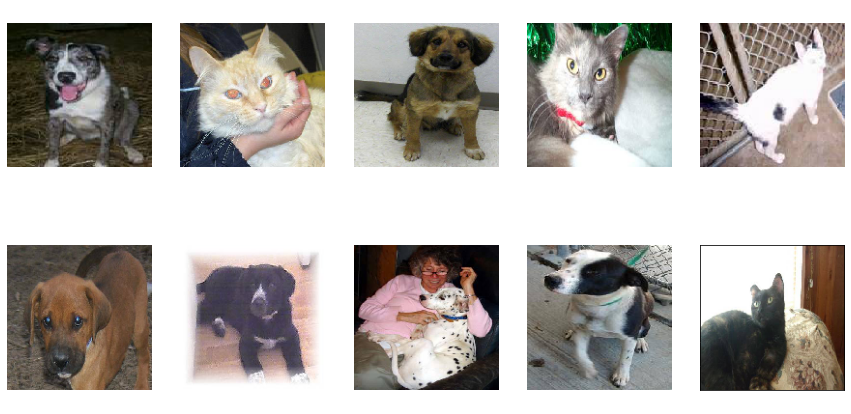

In [10]:
plot_images(sample_train_images, sample_train_labels)

In [11]:
m0 = build_model([
  Flatten(input_shape=image_size+(3,)),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              69121024  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 69,122,049
Trainable params: 69,122,049
Non-trainable params: 0
_________________________________________________________________


In [12]:
h0 = m0.fit(
  train_data_gen,
  epochs=epochs,
  steps_per_epoch=steps,
  validation_data=val_data_gen,
  validation_steps=steps // 2
)

Epoch 1/20
20/20 [==============================] - 7s 278ms/step - loss: 50.6798 - accuracy: 0.5039 - val_loss: 26.1288 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 5s 268ms/step - loss: 11.4828 - accuracy: 0.5108 - val_loss: 2.5910 - val_accuracy: 0.5406
Epoch 3/20
20/20 [==============================] - 5s 261ms/step - loss: 2.3608 - accuracy: 0.5507 - val_loss: 6.4439 - val_accuracy: 0.4922
Epoch 4/20
20/20 [==============================] - 5s 261ms/step - loss: 3.7660 - accuracy: 0.5420 - val_loss: 5.5447 - val_accuracy: 0.5125
Epoch 5/20
20/20 [==============================] - 5s 269ms/step - loss: 3.8390 - accuracy: 0.5444 - val_loss: 1.1576 - val_accuracy: 0.5766
Epoch 6/20
20/20 [==============================] - 5s 257ms/step - loss: 1.3742 - accuracy: 0.6041 - val_loss: 5.9007 - val_accuracy: 0.4938
Epoch 7/20
20/20 [==============================] - 5s 264ms/step - loss: 4.0588 - accuracy: 0.5278 - val_loss: 1.1575 - val_accuracy: 0.5719
Epo

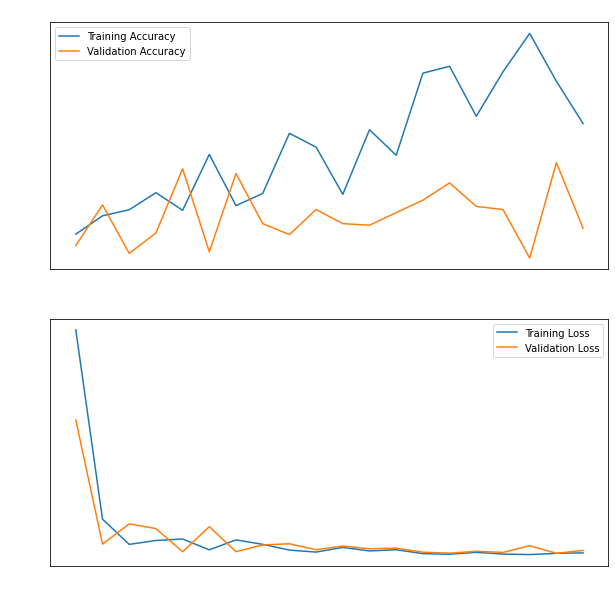

In [13]:
plot_model(h0)

In [14]:
augmented_image_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15
)

augmented_train_data_gen = augmented_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=image_size,
    class_mode='binary'
)

augmented_val_data_gen = augmented_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=image_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


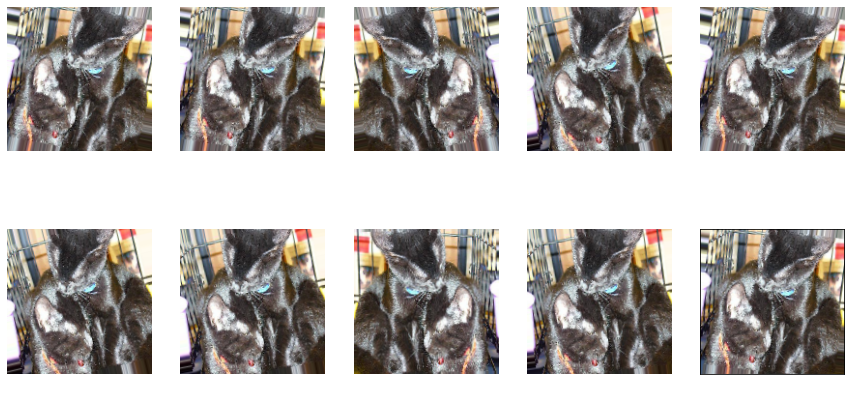

In [15]:
plot_images([augmented_train_data_gen[0][0][0] for i in range(10)])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              69121024  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 69,122,049
Trainable params: 69,122,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 11s 528ms/step - loss: 105.1200 - accuracy: 0.4894 - val_loss: 3.5613 - val_accuracy: 0.5578
Epoch 2/20
20/20 [==============================] - 10s 501ms/step - loss: 8.4593 - accuracy: 0

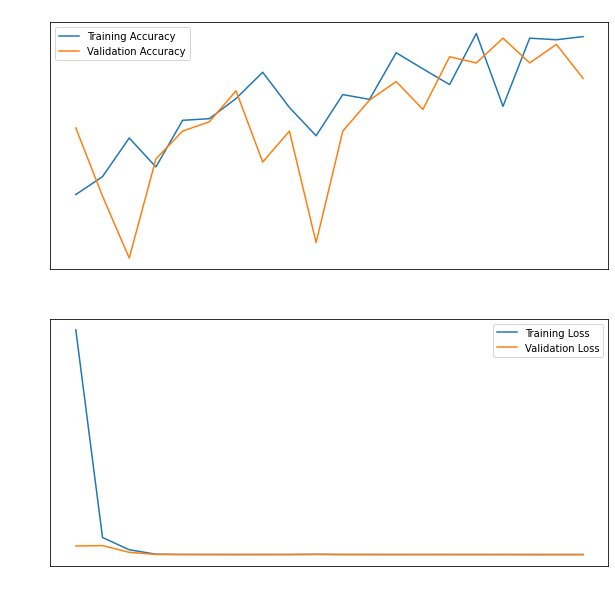

In [16]:
m1 = build_model([
  Flatten(input_shape=image_size+(3,)),
  Dense(1024, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

h1 = m1.fit(
  augmented_train_data_gen,
  epochs=epochs,
  steps_per_epoch=steps,
  validation_data=val_data_gen,
  validation_steps=steps // 2
)

plot_model(h1)

In [19]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=image_size+(3,))

feature_extractor_layer.trainable = False


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 20s 559ms/step - loss: 0.5040 - accuracy: 0.7952 - val_loss: 0.1517 - val_accuracy: 0.9484
Epoch 2/20
20/20 [==============================] - 11s 551ms/step - loss: 0.1540 - accuracy: 0.9561 - val_loss: 0.1181 - val_accuracy: 0.9625
Epoch 3/20
20/20 [==============================] - 11s 550ms/step - loss: 0.0901 

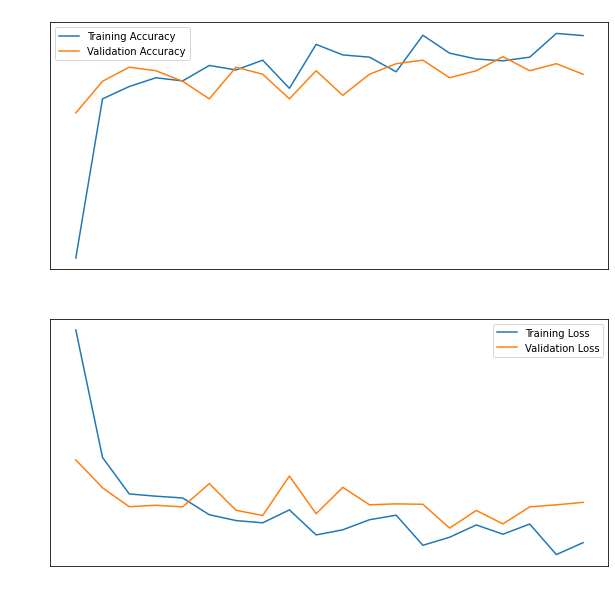

In [21]:
m2 = build_model([
  feature_extractor_layer,
  Dropout(0.2),
  Dense(1, activation='sigmoid')                 
])

h2 = m2.fit(
  augmented_train_data_gen,
  epochs=epochs,
  steps_per_epoch=steps,
  validation_data=val_data_gen,
  validation_steps=steps // 2
)

plot_model(h2)